<a href="https://www.kaggle.com/code/irfanqasim/brain-mri-segmentation?scriptVersionId=112361937" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cv2
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras import backend as K


In [3]:
img_height=256
img_width=256

In [4]:
# image_train_files = []

# mask_files = glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*")
# all_files = glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*")
# print(len(all_files))
# print(len(mask_files))
# for i in all_files:
#     if i not in mask_files:
#         image_train_files.append(i)
        
# print(len(image_train_files))

In [5]:
data_path = []
for sub_dir_path in glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    # starts at sub_dir_path = /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909
    try:
        #dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            #starts at filename = TCGA_CS_4941_19960909_1.tif
            file_path = sub_dir_path + '/' + filename
            data_path.append(file_path)
            #data_path.extend([dir_name, mask_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [6]:
data_path[1:10]

['/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33_mask.tif']

In [7]:
df = pd.DataFrame(data={"img_path": data_path})
df

,img_path
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...
7853,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7854,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7855,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7856,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [8]:
# Seperating the original image paths and mask image paths
orig_img = df[~df['img_path'].str.contains("mask")]
mask_img = df[df['img_path'].str.contains("mask")]

#### Sorting the file paths so that the same file numbers for both original image and mask image are present at a given index location in both the dataframes
#### We have to sort based on the numbers present in the end of the file path (before`.tif` extension in case of original image files and before `_mask.tif` in case of mask image files.

In [9]:
# We find that the numbers index location is 89 and we have to fetch until until -4 index(.tif) in case of 
# orig_img files and until -9 index(_mask.tif) postion in case of mask files
imgs = sorted(orig_img["img_path"].values, key=lambda x : int(x[89:-4]))
masks = sorted(mask_img["img_path"].values, key=lambda x : int(x[89:-9]))

# Sorting check
idx = np.random.randint(0, len(imgs)-1)
print("Image path:", imgs[idx], "\nMask path:", masks[idx])

Image path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_15.tif 
Mask path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_15_mask.tif


In [10]:
df = pd.DataFrame({"image_path": imgs, 'mask_path':masks})
df

,image_path,mask_path
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...,...,...
3924,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3925,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3926,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3927,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [11]:
indd = np.random.randint(1, len(df))
df.iloc[indd]['image_path'], df.iloc[indd]['mask_path']

('/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_22.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_22_mask.tif')

In [12]:
# Check whether mask is present or not
def check_mask(mask_path):
    img = cv2.imread(mask_path)
    max_val = img.max()
    if max_val > 0:
        return 1
    else:
        return 0

In [13]:
# Creating a new 'mask' column which shows if mask is present or not
df['mask'] = df['mask_path'].apply(lambda x: check_mask(x))
df

,image_path,mask_path,mask
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...
3924,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [14]:
print(f"Number of images with mask: {len(df[df['mask'] == 1])}")
print(f"Number of images without mask: {len(df[df['mask'] == 0])}")

Number of images with mask: 1373
Number of images without mask: 2556


In [15]:
df.iloc[2]['mask']

0

Image id: 1975
Image id: 1977
Image id: 1979


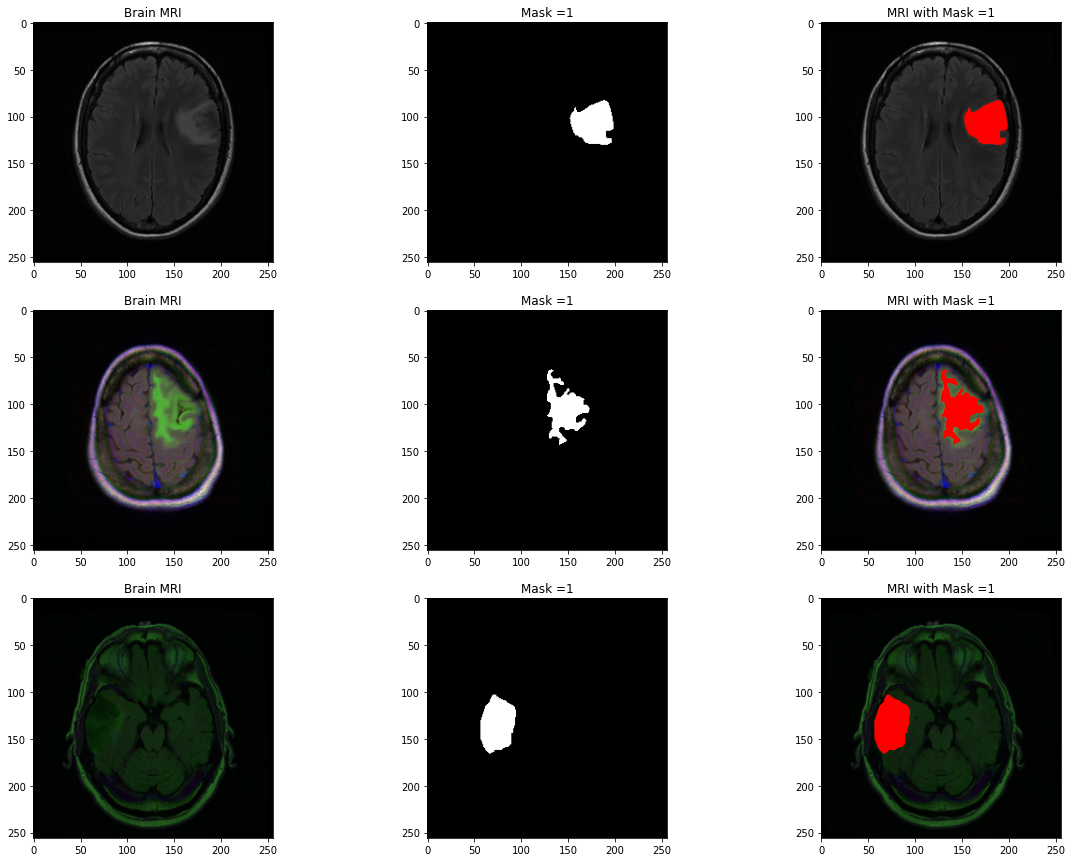

In [16]:
from IPython.display import Image
from skimage import io

count = 0
# generating random number for geenrating random image
i = np.random.randint(len(df)-3)

fig,axes = plt.subplots(3,3, figsize=(20,15))
for mask in df['mask']:
    # plot only if the generated random index mask is 1, otherwise increment 1
    if df.iloc[i]['mask'] == 1:
    #if (mask==1):
        print("Image id: {}".format(i))
        img = io.imread(df.image_path[i])
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[count][0].title.set_text("Brain MRI")
        axes[count][0].imshow(img)
        
        mask = io.imread(df.mask_path[i])
        axes[count][1].title.set_text("Mask =" + str(df['mask'][i]))
        axes[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[count][2].title.set_text("MRI with Mask =" + str(df['mask'][i]))
        axes[count][2].imshow(img)
        count +=1
    i += 1
    if (count==3):
        break
        
fig.show()

/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1_mask.tif
/kaggle/input/lgg-mri-seg

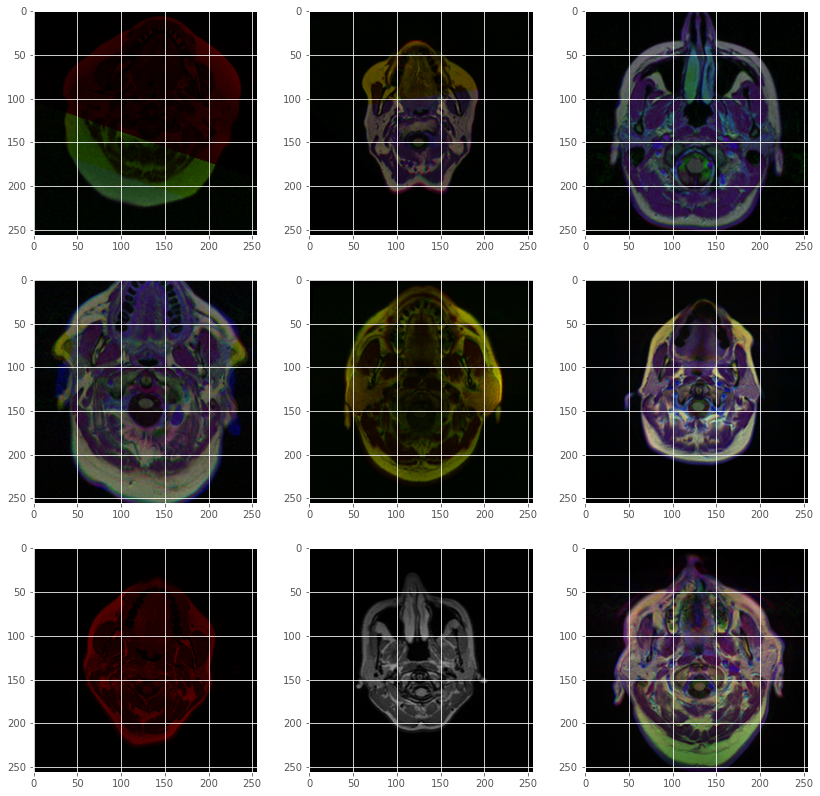

In [17]:
def plot_from_path(rows, col, img_pth, mask_pth):
    fig = plt.figure(figsize=(14,14))
    plt.style.use("ggplot")
    for i in range(rows*col):
        fig.add_subplot(rows, col, i+1)
        print(img_pth[i])
        img = cv2.imread(img_pth[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print(mask_pth[i])
        mask = cv2.imread(mask_pth[i])
        plt.imshow(img)
        plt.imshow(mask, cmap='gray', alpha=.1)
    plt.show()

plot_from_path(3,3, df.image_path, df.mask_path)

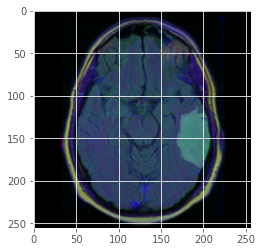

In [18]:
img_ck = cv2.imread(df.image_path[818])
msk_ck = cv2.imread(df.mask_path[818])
img_ck = cv2.cvtColor(img_ck, cv2.COLOR_BGR2RGB)
img_ck = img_ck/255
msk_ck = msk_ck/255
plt.imshow(img_ck)
plt.imshow(msk_ck, cmap='gray', alpha=.1)

In [19]:
print(img_ck.max(),img_ck.min())
print(msk_ck.max(), msk_ck.min())

0.8588235294117647 0.0
1.0 0.0


Creating a dataframe from image files and mask files

**Train, test and validation split**

In [20]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=2)
# validation split
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=2)
print("Train shape: {}\nTest shape: {}\nValidation shape: {}".format(df_train.shape, df_test.shape, df_val.shape))

Train shape: (2828, 3)
Test shape: (393, 3)
Validation shape: (708, 3)


Passing data batchwise to my model using a data generator.

*After mask normalization if a particular value is less than 0.5, then that mask will be considered complete black without any tumor.*

In [21]:
# normalising and setting mask threshold
def normalise_and_set_threshold(image, mask):
    image = image/255
    mask = mask/255
    mask[mask>0.5] = 1
    mask[mask<=0.5] = 0
    return (image, mask)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_generator(dataframe, batch_size, augmentation_dict, target_size = (256,256), image_color_mode='rgb', 
                    mask_color_mode='grayscale', image_save_prefix='image', mask_save_prefix='mask',
                   save_to_dir= None, seed=2):
    
    # ImageDataGenerator generate batches of tensor image data with real-time data augmentation.
    image_data_generator = ImageDataGenerator(**augmentation_dict)
    mask_data_generator = ImageDataGenerator(**augmentation_dict)
    
    image_generator = image_data_generator.flow_from_dataframe(dataframe=dataframe,
                                                              x_col = 'image_path',
                                                              target_size=target_size,
                                                              color_mode = image_color_mode,
                                                              class_mode=None,  # modes for yielding the target, None means no targets returned
                                                              batch_size=batch_size,
                                                              seed=seed,
                                                              save_to_dir=save_to_dir,
                                                              save_prefix=image_save_prefix)
    mask_generator = mask_data_generator.flow_from_dataframe(dataframe = dataframe,
                                                            x_col= 'mask_path',
                                                            target_size = target_size,
                                                            color_mode = mask_color_mode,
                                                            class_mode = None,
                                                            batch_size = batch_size,
                                                            seed = seed,
                                                            save_to_dir= save_to_dir,
                                                            save_prefix= mask_save_prefix)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = normalise_and_set_threshold(img, mask)
        yield (img, mask)

Dice Score is given by 2 times the area of overlap divided by total number of pixels in both images.

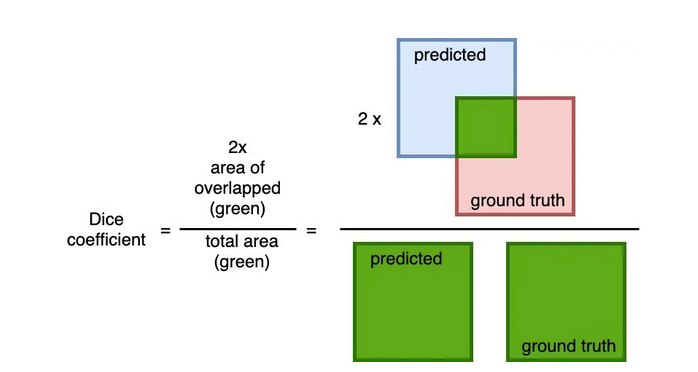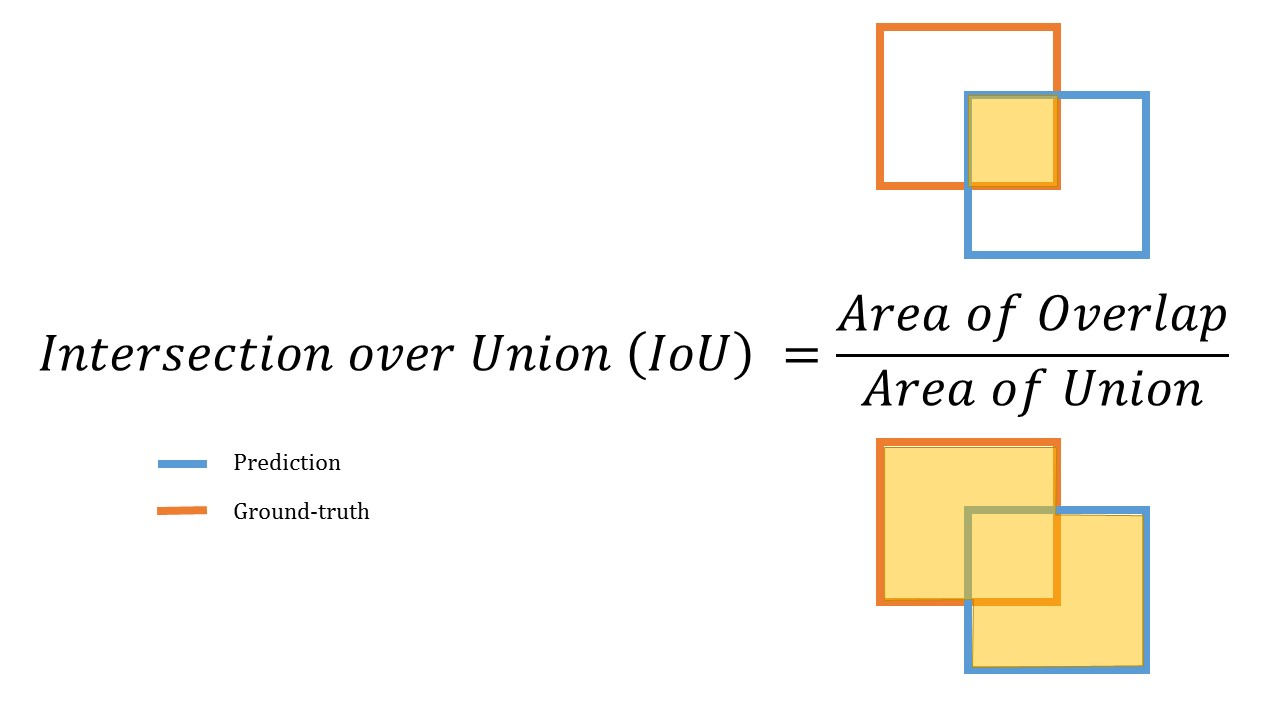

In [23]:
def dice_coeff(ytrue, ypred, smooth=100):
    ytrue_flat = K.flatten(ytrue)
    ypred_flat = K.flatten(ypred)
    
    intersection = K.sum(ytrue_flat * ypred_flat)
    total_area = K.sum(ytrue_flat) + K.sum(ypred_flat)
    return (2*intersection + smooth)/(total_area + smooth)

def dice_coeff_loss(ytrue,ypred, smooth=100):
    return 1-dice_coeff(ytrue, ypred, smooth)

def iou_coeff(ytrue, ypred, smooth=100):
    intersection = K.sum(ytrue * ypred)
    union = K.sum(ytrue + ypred) - intersection
    return (intersection + smooth)/(union + smooth)

def jaccard_distance(ytrue, ypred):
    ytrue_flat = K.flatten(ytrue)
    ypred_flat = K.flatten(ypred)
    return 1-iou_coeff(ytrue_flat, ypred_flat)

## UNET Architecture

In [24]:
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, MaxPooling2D, 
                                     Dropout, Activation, BatchNormalization, concatenate)
from tensorflow.keras.models import Model, load_model, save_model

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    # Expansion Path or Encoder network
    c1 = Conv2D(filters=64, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(inputs)
    c1 = Conv2D(filters=64, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(c1)
    bn1 = BatchNormalization(axis=3)(c1)
    p1 = MaxPooling2D(pool_size=(2,2))(bn1)
    
    
    c2 = Conv2D(filters=128, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(p1)
    c2 = Conv2D(filters=128, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(c2)
    bn2 = BatchNormalization(axis=3)(c2)
    p2 = MaxPooling2D(pool_size=(2,2))(bn2)
    
    c3 = Conv2D(filters=256, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(p2)
    c3 = Conv2D(filters=256, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(c3)
    bn3 = BatchNormalization(axis=3)(c3)
    p3 = MaxPooling2D(pool_size=(2,2))(bn3)
    
    c4 = Conv2D(filters=512, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(p3)
    c4 = Conv2D(filters=512, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(c4)
    bn4 = BatchNormalization(axis=3)(c4)
    p4 = MaxPooling2D(pool_size=(2,2))(bn4)
    
    c5 = Conv2D(filters=1024, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(p4)
    c5 = Conv2D(filters=1024, kernel_size = (3,3), activation='relu', padding = 'same', kernel_initializer='lecun_normal')(c5)
    bn5 = BatchNormalization(axis=3)(c5)
    
    # Compression path or Decoder network
    u6 = Conv2DTranspose(filters = 512, kernel_size=(2,2), strides=(2,2), padding='same')(bn5)
    u6 = concatenate([u6,c4], axis=3)
    c6 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='lecun_normal')(u6)
    c6 = Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='lecun_normal')(c6)
    bn6 = BatchNormalization(axis=3)(c6)
    
    u7 = Conv2DTranspose(filters = 256, kernel_size=(2,2), strides=(2,2), padding='same')(bn6)
    u7 = concatenate([u7,c3], axis=3)
    c7 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='lecun_normal')(u7)
    c7 = Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='lecun_normal')(c7)
    bn7 = BatchNormalization(axis=3)(c7)
    
    u8 = Conv2DTranspose(filters = 128, kernel_size=(2,2), strides=(2,2), padding='same')(bn7)
    u8 = concatenate([u8,c2], axis=3)
    c8 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='lecun_normal')(u8)
    c8 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='lecun_normal')(c8)
    bn8 = BatchNormalization(axis=3)(c8)
    
    u9 = Conv2DTranspose(filters = 64, kernel_size=(2,2), strides=(2,2), padding='same')(bn8)
    u9 = concatenate([u9,c1], axis=3)
    c9 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='lecun_normal')(u9)
    c9 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='lecun_normal')(c9)
    bn9 = BatchNormalization(axis=3)(c9)
    
    c10 = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(bn9)
    
    return Model(inputs=[inputs], outputs = [c10])

In [25]:
augmentation_dict = dict(rotation_range=0.1,
                        width_shift_range = 0.05,
                        height_shift_range = 0.1,
                        brightness_range = (0.3,1.2),
                        shear_range = 0.05,
                        zoom_range = 0.1,
                        horizontal_flip = True,
                        vertical_flip = True,
                        fill_mode = 'nearest')

batch_size = 32
epochs = 100
learning_rate = 1e-3

train_gen = train_generator(df_train, batch_size, augmentation_dict, target_size = (img_height, img_width))
val_gen = train_generator(df_val, batch_size, dict(), target_size=(img_height, img_width))


In [26]:
# initializing our unet model
model = unet(input_size = (img_height, img_width, 3))

2022-11-28 14:29:10.446689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 14:29:10.455391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 14:29:10.456111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 14:29:10.457580: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [27]:
# setting our optimizer and compiling
decay_rate = learning_rate/epochs

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999,
                                    epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=optimizer, loss=dice_coeff_loss, metrics=['binary_accuracy',dice_coeff, iou_coeff])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [28]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# callbacks = [ModelCheckpoint('mri_seg_unet.hdf5', verbose=1, save_best_only=True)]

In [29]:
# my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss', restore_best_weights=True),
#                 tf.keras.callbacks.ModelCheckpoint('mri_seg_unet.hdf5', verbose=1, save_best_only=True),
#                 tf.keras.callbacks.TensorBoard(log_dir='logs')]
my_callbacks = [tf.keras.callbacks.ModelCheckpoint('mri_seg_unet.hdf5', verbose=1, save_best_only=True)]

In [30]:
steps_per_epoch = len(df_train)/batch_size
val_steps = len(df_val)/batch_size

history = model.fit(train_gen, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=my_callbacks, 
                    validation_data=val_gen, validation_steps=val_steps)

Found 2828 validated image filenames.
Found 2828 validated image filenames.


2022-11-28 14:31:02.224276: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-11-28 14:31:04.442720: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


89/88 [==============================] - ETA: 0s - loss: 0.8818 - binary_accuracy: 0.8938 - dice_coeff: 0.1201 - iou_coeff: 0.0657Found 708 validated image filenames.
Found 708 validated image filenames.
88/88 [==============================] - 111s 1s/step - loss: 0.8818 - binary_accuracy: 0.8938 - dice_coeff: 0.1201 - iou_coeff: 0.0657 - val_loss: 0.9882 - val_binary_accuracy: 0.9908 - val_dice_coeff: 0.0494 - val_iou_coeff: 0.0494

Epoch 00001: val_loss improved from inf to 0.98818, saving model to mri_seg_unet.hdf5
Epoch 2/100
88/88 [==============================] - 88s 1s/step - loss: 0.7449 - binary_accuracy: 0.9671 - dice_coeff: 0.2549 - iou_coeff: 0.1527 - val_loss: 0.9688 - val_binary_accuracy: 0.9909 - val_dice_coeff: 0.0317 - val_iou_coeff: 0.0198

Epoch 00002: val_loss improved from 0.98818 to 0.96881, saving model to mri_seg_unet.hdf5
Epoch 3/100
88/88 [==============================] - 88s 1s/step - loss: 0.5524 - binary_accuracy: 0.9893 - dice_coeff: 0.4499 - iou_coeff:

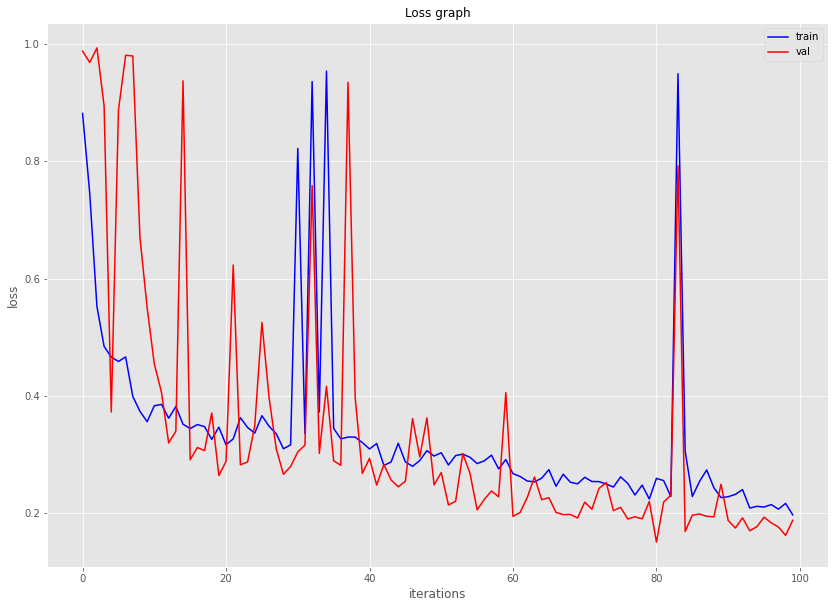

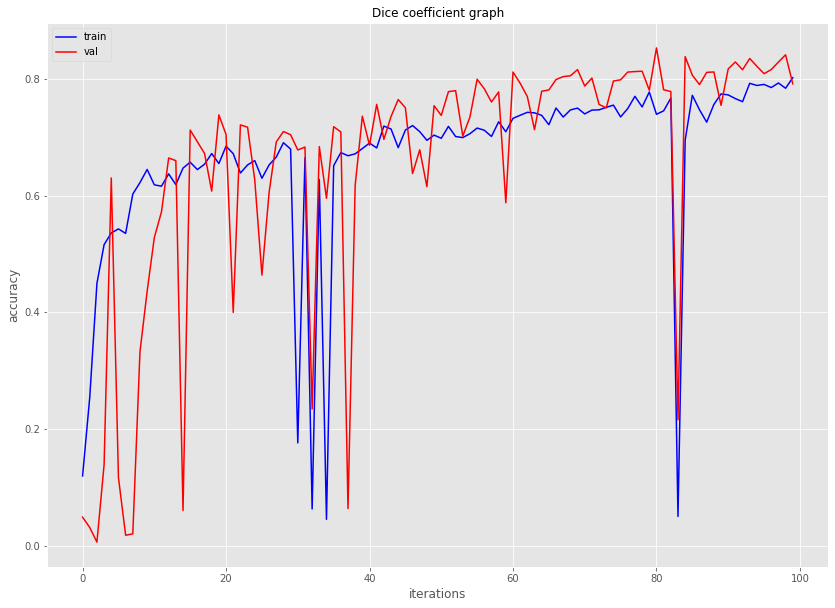

In [36]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coeff']
val_dice_coeff_list = history_post_training['val_dice_coeff']

train_jaccard_list = history_post_training['iou_coeff']
val_jaccard_list = history_post_training['val_iou_coeff']

train_loss_list = history_post_training['loss']
val_loss_list = history_post_training['val_loss']

plt.figure(figsize=(14,10))
plt.figure(1)
plt.plot(train_loss_list, 'b-')
plt.plot(val_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss graph', fontsize=12)
plt.legend(['train', 'val']);

plt.figure(figsize=(14,10))
plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(val_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Dice coefficient graph', fontsize=12)
plt.legend(['train', 'val']);
plt.show()

In [37]:
model = load_model('mri_seg_unet.hdf5', custom_objects={'dice_coeff_loss': dice_coeff_loss, 
                                                        'iou_coeff': iou_coeff,
                                                        'dice_coeff': dice_coeff})

In [38]:
test_gen = train_generator(dataframe=df_test, batch_size=batch_size, augmentation_dict=dict(), target_size=(img_height, img_width))

results = model.evaluate(test_gen, steps=len(df_test)/batch_size)

print("Test Loss is: {}\nTest IoU is: {}\nTest Dice Coefficient is: {}".format(results[0], results[1], results[2]))

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 7s 564ms/step - loss: 0.1549 - binary_accuracy: 0.9965 - dice_coeff: 0.8379 - iou_coeff: 0.7260
Test Loss is: 0.15486623346805573
Test IoU is: 0.9964997172355652
Test Dice Coefficient is: 0.8379498720169067


In [ ]:
count = 0
fig, axs = plt.subplots(3,5, figsize=(30,15))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.img_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Ground Truth')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.img_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with PREDICTED MASK')
        
        count +=1
    if (count==3):
        break

fig.tight_layout()

In [40]:
df_test

,image_path,mask_path,mask
2048,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
1364,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
2374,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
3728,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1452,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...
240,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2718,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
2109,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
1067,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1


In [ ]:
from IPython.display import Image
from skimage import io

count = 0
# generating random number for geenrating random image
i = np.random.randint(len(df)-3)

fig,axes = plt.subplots(3,3, figsize=(20,15))
for mask in df['mask']:
    # plot only if the generated random index mask is 1, otherwise increment 1
    if df.iloc[i]['mask'] == 1:
    #if (mask==1):
        print("Image id: {}".format(i))
        img = io.imread(df.image_path[i])
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[count][0].title.set_text("Brain MRI")
        axes[count][0].imshow(img)
        
        mask = io.imread(df.mask_path[i])
        axes[count][1].title.set_text("Mask =" + str(df['mask'][i]))
        axes[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[count][2].title.set_text("MRI with Mask =" + str(df['mask'][i]))
        axes[count][2].imshow(img)
        count +=1
    i += 1
    if (count==3):
        break
        
fig.show()

In [93]:
imgg = cv2.imread(df_test['image_path'].iloc[34])
imgk = cv2.resize(imgg, (img_height, img_width))
imgl = imgk/255
# print(img.shape) (256, 256 , 3)
imgx = imgk[np.newaxis, :, :, : ]
img2 = np.squeeze(imgx)
#img_ck = cv2.imread(df.image_path[818])
#img_ck = cv2.cvtColor(img_ck, cv2.COLOR_BGR2RGB)

#imgg = cv2.imread(df_test['image_path'])

#imgg = cv2.imshow(df_test['image_path'].iloc[index], y.astype('float32'))
img1 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
#img1 = cv2.imshow(imgg, imgg.astype(np.uint8))
# img1 = img.convert('L')
imgg.shape, imgk.shape, imgl.shape, imgx.shape, img2.shape, img1.shape

((256, 256, 3),
 (256, 256, 3),
 (256, 256, 3),
 (1, 256, 256, 3),
 (256, 256, 3),
 (256, 256))

In [96]:
pred = np.array(predicted_img).squeeze().round()
pred1 = predicted_img.squeeze()
pred.shape
print(predicted_img.shape, pred1.shape)

(1, 256, 256, 1) (256, 256)


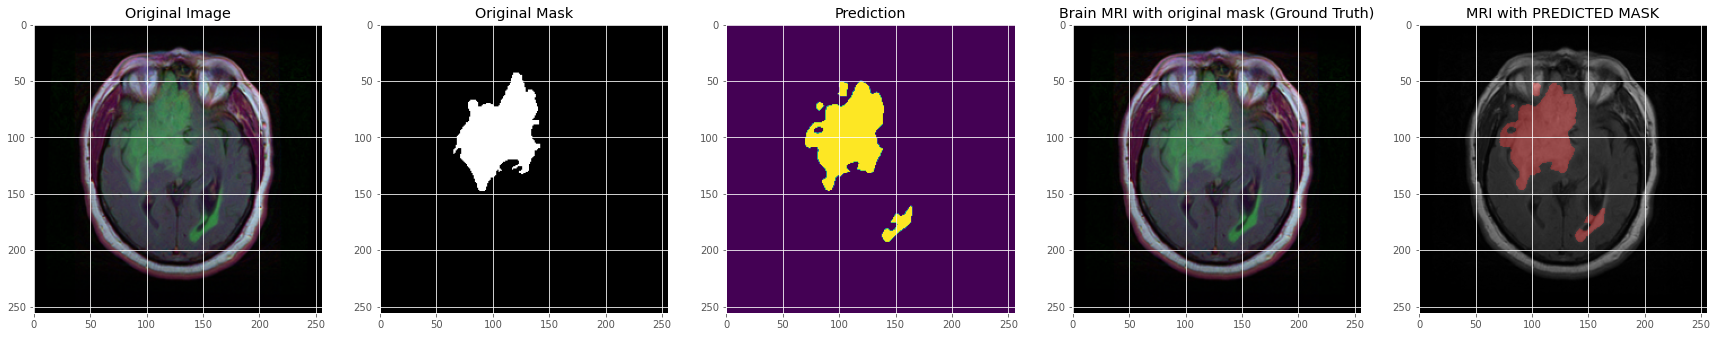

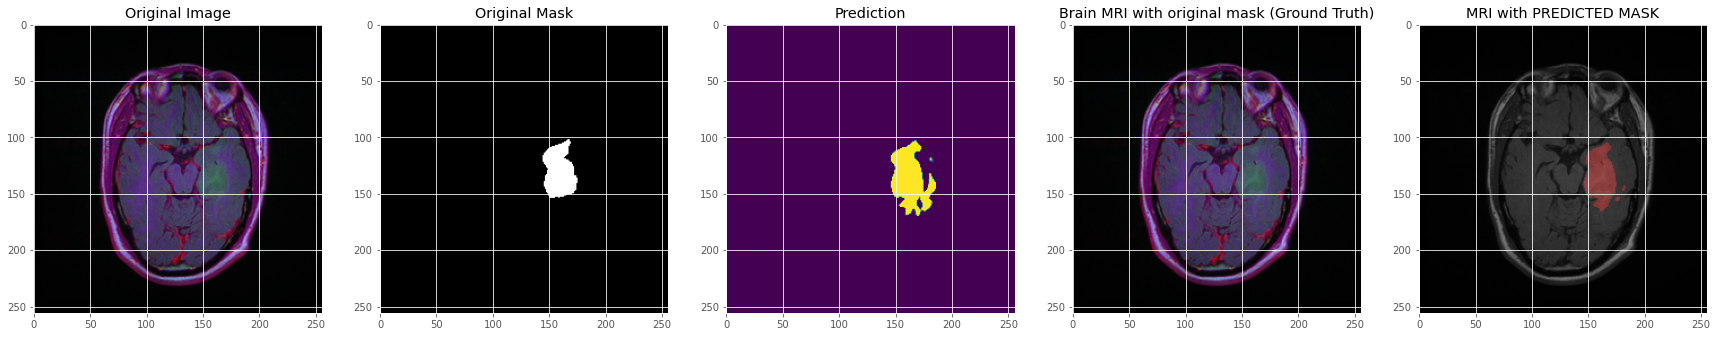

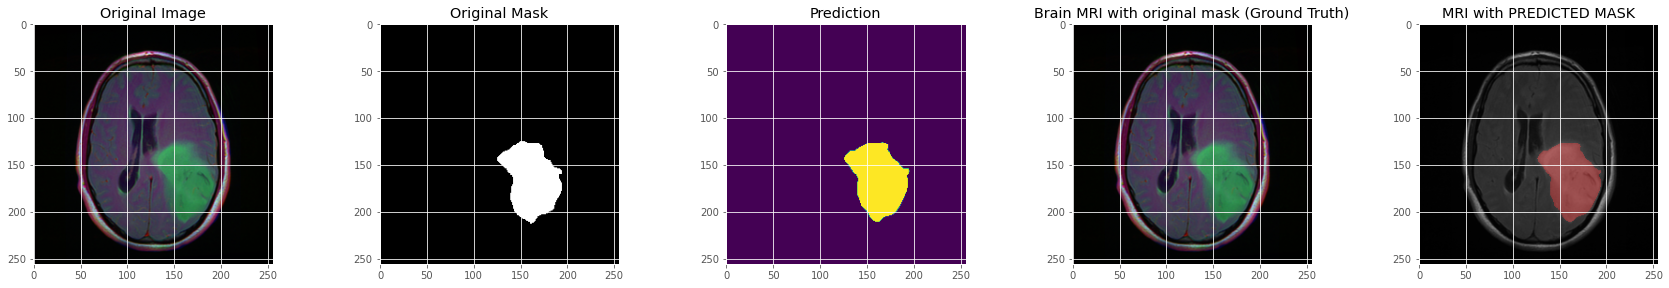

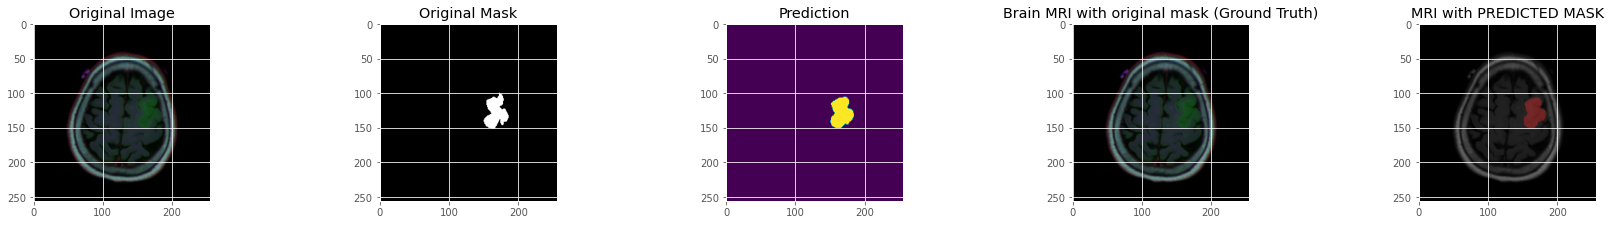

In [98]:
from skimage import color
index = np.random.randint(1, len(df_test.index))
ct = 1
#fig,axes = plt.subplots(10,3)
for mask in df_test['mask']:
    if df_test.iloc[index]['mask'] == 1:
        img = cv2.imread(df_test['image_path'].iloc[index])
        img = cv2.resize(img, (img_height, img_width))
        img = img/255
        # print(img.shape) (256, 256 , 3)
        img = img[np.newaxis, :, :, : ]
        # print(img.shape) # (1, 256, 256, 3)

        predicted_img = model.predict(img)
        
        # original image
        plt.figure(figsize=(30, 15))
        plt.subplot(ct, 5, 1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')

        # ground truth mask
        #plt.figure(figsize=(8, 8))
        plt.subplot(ct, 5, 2)
        # np.squeeze shrinks one dim from (1,256,256,3) to (256,256,3)
        plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
        plt.title('Original Mask')

        # predicted mask
        #plt.figure(figsize=(8, 8))
        plt.subplot(ct, 5, 3)
        plt.imshow(np.squeeze(predicted_img))
        plt.title('Prediction')
        
        #overlay original mask on original image
        plt.subplot(ct,5,4)
        img[mask==255] = (255,0,0)
        plt.imshow(np.squeeze(img))
        plt.title('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask on original image
        plt.subplot(ct, 5, 5)
        img1 = cv2.imread(df_test['image_path'].iloc[index])
        img1 = cv2.resize(img1, (img_height, img_width))
        # the predicted mask image and original image should have same shape
        # so converting original image (256,256,3) to gray scale (256,256)
        gray_img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        result_image = color.label2rgb(np.squeeze(predicted_img), gray_img)
        plt.imshow(result_image)
        plt.title('MRI with PREDICTED MASK')
        
        ct = ct+1
    index += 1
    if ct == 5:
        break

plt.show()

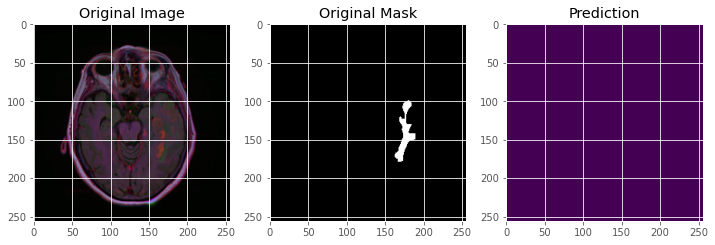

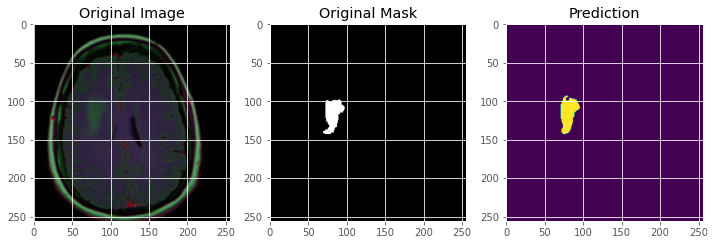

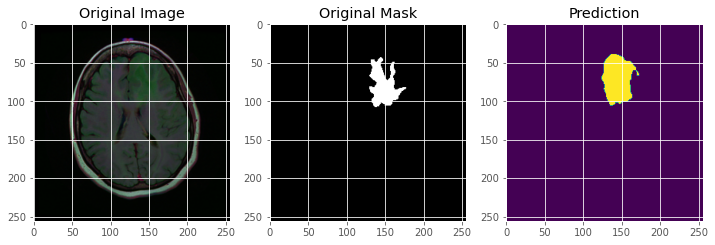

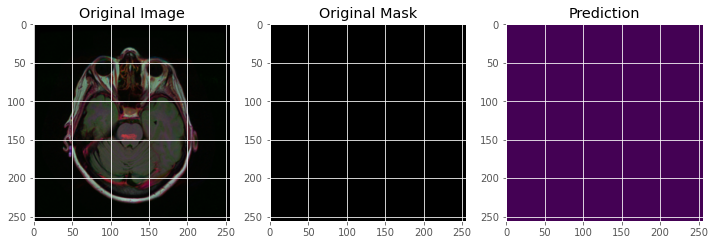

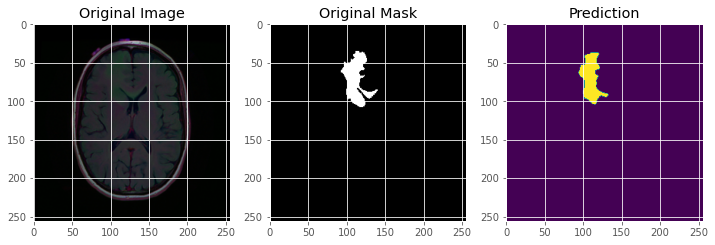

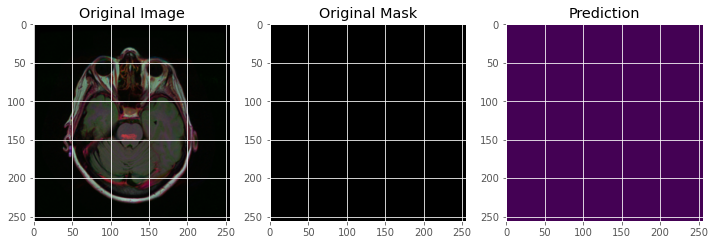

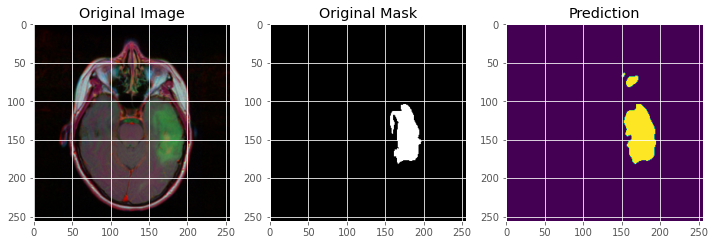

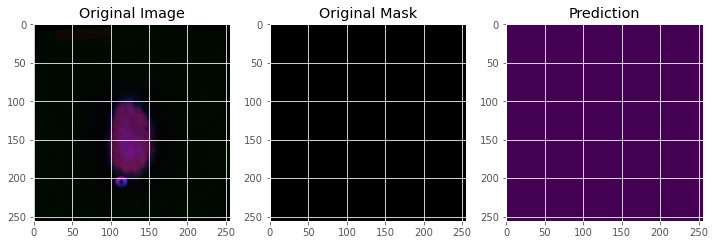

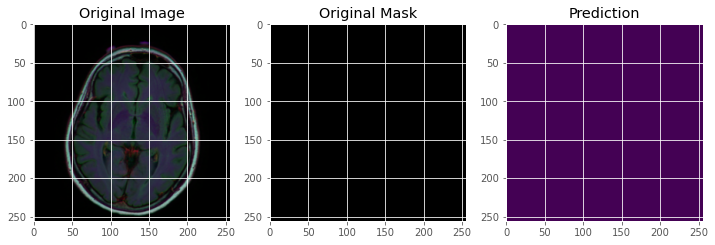

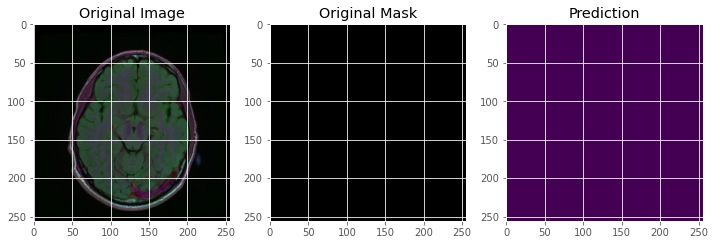

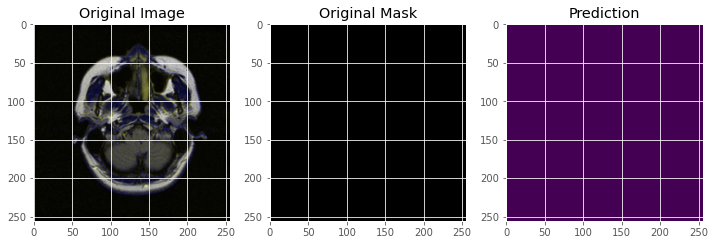

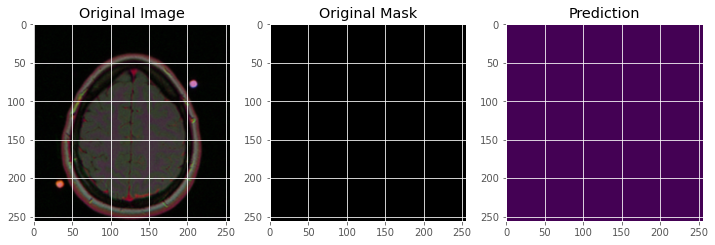

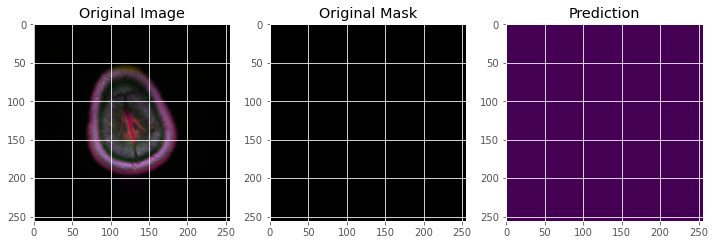

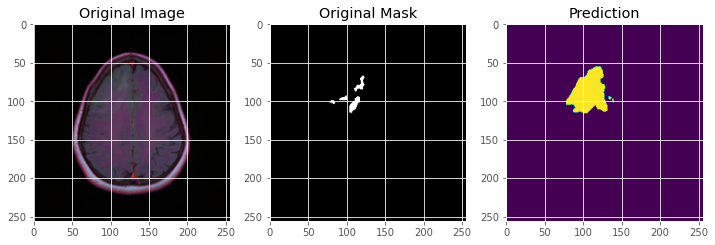

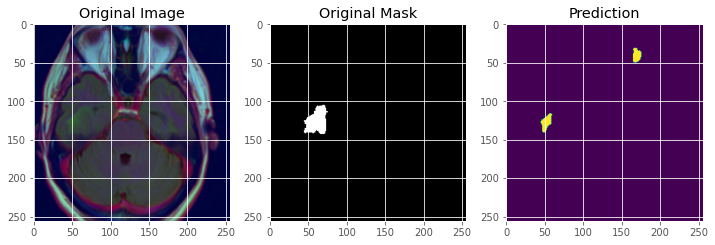

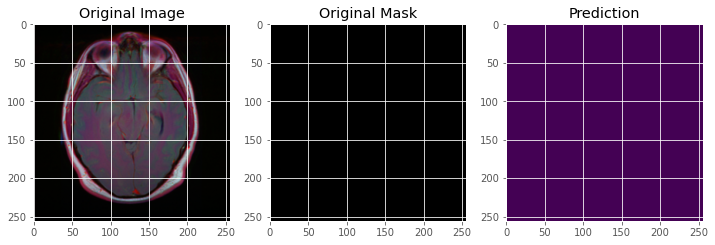

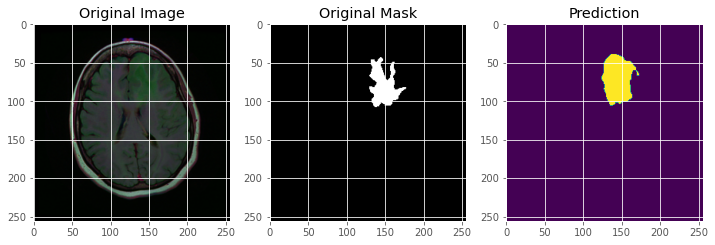

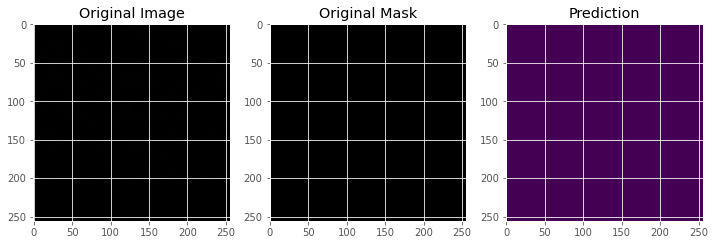

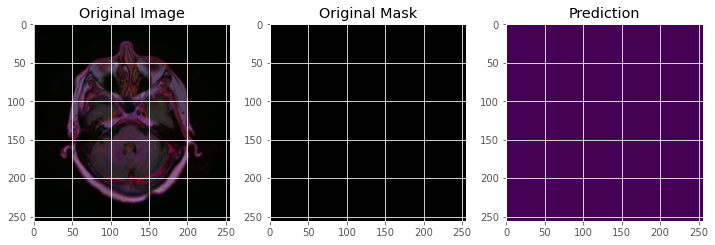

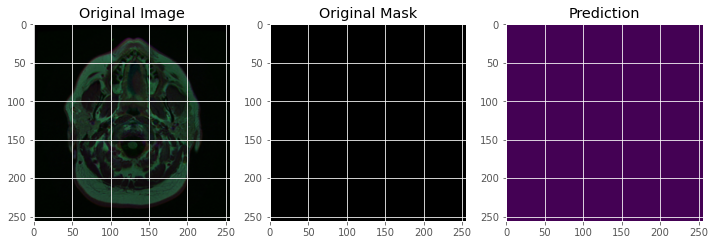

In [51]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img, (img_height, img_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()
